# Reinforcement Learning

The next set of algorithms we will cover deal with reinforcement learning. Reinforcement learning (also called online learning because it is done in real time) is used to solve interactive problems where the data up to time *t* is used to determine what action to perform at time *t+1*. These sort of algorithms are used to help machines learn to walk, with positive outcomes associated with a reward and negative outcomes punished. The two algorithms we will cover in this section are Upper Confidence Bound and Thompson Sampling.

# Upper Confidence Bound (UCB)

To begin learning reinforcement algorithms, we will first define a problem that we will attempt to solve, called the multi-armed bandit problem. Imagine we are in a casino and we have five slot machines in front of us. Each of these machines is independent and each machine has an underlying distribution which determines the outcome of the game. The problem is, you don't know what these underlying distributions are. You have decided that you are going to play 1000 rounds of slots, and your goal is to figure out which machine has the best distribution in order to maximize your winnings. The first step is obviously to explore these machines and get some first clues as to what machines are good and which are bad. There is a tradeoff right away that we must address. The more we explore, the more time we play on sub-optimal machines (ergo hurting our overall winnings), but if we don't explore enough, then we may not actually find the best machine to exploit. 

Let us rework this problem into a real world example. Assume we are working for a company that wants to start a new marketing campaign. They have ten different versions of the ad and they want to find out which add is best so that they can only use that one. Each ad has an underlying distribution which determines if a customer clicks on it or not. Obviously, we need some exploration, but we want to start favoring the better ads as soon as possible to maximize profits. Let us quickly formalize this problem.

1. We have *d* different ads.
2. Each time a user connects to a web page, we consider this one round.
3. During each round *n*, we pick an ad to display to the user.
4. During each round *n*, ad *i* gives reward $r_i(n) \in {0,1}:\text{ }r_i(n)=1\text{ if the user clicks on the ad, } 0$ if they didn't.
5. Our goal is to maximize rewards over all rounds.

Using this set-up, we define our algorithm as follows:

1. At each round *n*, we consider two values for each ad *i*:
 * $N_i(n)$ - the number of times ad *i* was selected up to round *n*
 * $R_i(n)$ - the sum of the rewards if the ad *i* up to round *n*.
2. From these numbers, compute:
 * the average reward of ad *i* up to round *n* as $\overline{r}_i(n) = \frac{R_i(n)}{N_i(n)}$
 * the confidence interval [$\overline{r}_i(n) - \Delta_i(n), \overline{r}_i(n) + \Delta_i(n)$] where $\Delta_i(n)=\sqrt{\frac{3log(n)}{2N_i(n)}}$.
3. Select the ad *i* which has the maximum UCB, $\overline{r}_i(n) + \Delta_i(n)$.

Intuitively, what we are doing is starting all machines at the same level. In other words, we start all machines with the same expected values and confidence intervals. Each time we choose and ad and get feedback, we move the expected value to reflect our new data and shrinks the confidence interval as well. What this algorithm does is exploit the best ad at the time and if that ad isn't doing well, the expected value and confidence interval for that ad will lower and a new ad will be selected. So exploration and exploitation happen in real time. 

Our data contains data for 10 ads where each row (or round as we have been describing) details whether that ad was clicked on round *i*. Obviously, we wouldn't have this full dataset as it would be collected in real time and we will act as though we can't see all the data and go round by round. We will first run the experiment choosing randomly and then implement the UCB algorithm to see how much better it does. 

First we run the experiment and output our total reward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('data/Ads_CTR_Optimisation.csv')

# Implementing Random Selection
import random
N = 10000
d = 10
ads_selected = []
total_reward = 0
for n in range(0, N):
    ad = random.randrange(d)
    ads_selected.append(ad)
    reward = dataset.values[n, ad]
    total_reward = total_reward + reward
    
print(total_reward)

1197


So our ads got clicked 1197 times, which given that we ran the experiment 10000 times isn't great. We next plot a histogram of the ad choices.

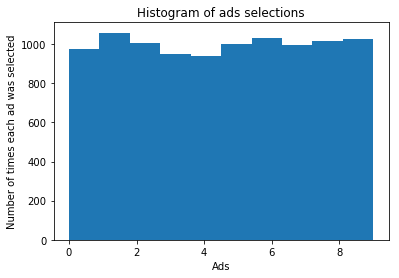

In [2]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

We see that each ad was chosen roughly the same number of times, as we would expect in a random selection. Now we will perform the same experiment using the UCB algorithm. We first run the test and see if our overall reward improves. At this point, we will not step through the python code but it should be easy to follow along and see what is happening.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('data/Ads_CTR_Optimisation.csv')

# Implementing UCB
import math
N = 10000
d = 10
ads_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d
total_reward = 0
for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
    ads_selected.append(ad)
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1
    reward = dataset.values[n, ad]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward
    total_reward = total_reward + reward

print(total_reward)

2178


We see through simply using this algorithm, we approximately doubled our reward. Now let us see how the distribution changed.

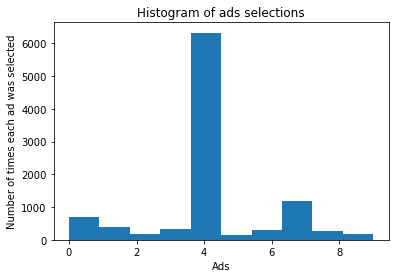

In [5]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

We can now see that certain ads were chosen far more often than others. These ads were presumably the ones that performed the best.

# Thompson Sampling

We are going to use the same problem defined above to talk about Thompson Sampling. The Thompson Sampling algorithm is a probabilistic algorithm and thus a fair bit of math is involved in explaining it, but we will keep things fairly high level and just understand the intuition. The idea behind the Thompson Sampling is a bit tricky, so let us walk through step by step. Recall in the UCB algorithm that we assumed each ad had an underlying distribution and throughout our various rounds, we were trying to approximate these distributions as we went along, favoring ads with better distributions. This time, we again assume that each ad has an underlying distribtuion, but we are not trying to approximate it. Instead, we are creating distributions for the expected value of each ad. So using the information we have for each ad (how many times has that ad succeeded and how many times has it not), we can create a distribution for the expected value of that ad. We do this for every ad, and then choose a random value for each distribution. The ad with the highest random value is the one we choose next. We will use the Beta distribtion as our distribution for the expected value. The Beta distribution takes in two parameters, $\alpha$ and $\beta$. Noting that we have the setup for a Bernoulli distribution (we can have either a success or failure at each round with some probability), and the Beta distribution is the conjugate prior for the Bernoulli distribution, the Beta distribution with $\alpha$ equal to the number of successes for an ad and $\beta$ equal to the number of failures for each ad is a logical choice. A conjugate prior simply means that the prior and posterior distributions are part of the same family. We do not need to concern ourselves too much with the underlying mathematics, we just need to understand that they translate to the following algorithm:

1. At each round *n*, consider two numbers for each ad *i*:
 * $N_i^1(n)$ - the number of times ad *i* got reward *1* up to round *n*
 * $N_i^0(n)$ - the number of times ad *i* got reward *0* up to round *n*
2. For each ad *i*, take a random draw from the following distribution: $\Theta_i(n) = \beta(N_i^1(n)+1, N_i^0(n) + 1)$.
3. Select the ad with the highest $\Theta_i(n)$.

We implement this algorithm and see how it performs versus the random sampling and UCB from above. First we read in the data, run the model, and see our reward.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('data/Ads_CTR_Optimisation.csv')

# Implementing Thompson Sampling
import random
N = 10000
d = 10
ads_selected = []
numbers_of_rewards_1 = [0] * d
numbers_of_rewards_0 = [0] * d
total_reward = 0
for n in range(0, N):
    ad = 0
    max_random = 0
    for i in range(0, d):
        random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1)
        if random_beta > max_random:
            max_random = random_beta
            ad = i
    ads_selected.append(ad)
    reward = dataset.values[n, ad]
    if reward == 1:
        numbers_of_rewards_1[ad] = numbers_of_rewards_1[ad] + 1
    else:
        numbers_of_rewards_0[ad] = numbers_of_rewards_0[ad] + 1
    total_reward = total_reward + reward
    
print(total_reward)

2607


We see that this algorithm outperformed both the UCB and the random sampling. An important thing to note about this algorithm is that it is probabilistic, so if we ran the above simulation again, we would likely get a different result. Now let us plot the histogram of the ad selection.

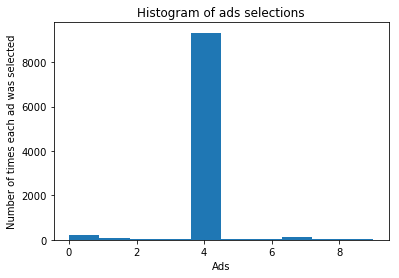

In [7]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

We get a histogram similiar to that of the UCB, but it seemed to choose what is saw as the best ad much more than the UCB. This means that it latches onto the optimal ad earlier than the UCB.

# Comparison of the Two Algorithms

It is now useful to speak a litle of how the UCB algorithm compares with the Thomspon Sampling. One pro for the UCB is that it is easier to understand since it takes less math to get the idea. Thompson Sampling has even deeper math imvolving Bayenesian Inference, but this was skipped to keep this overview higher level, but there is certainly quite a bit of math needed to understand the Thompson Sampling algorithm. That being said, Thompson Sampling outperforms the UCB algorithm in general, which is certainly a strong pro for the Thompson Sampling. Another strong pro for the Thompson Sampling is that it is probabilistic, meaning we could run the same round over and over and get different results. UCB is deterministic, meaning if we re-run the same round, we always get the same results. The implications of this are that we have to update the UCB algorithm every round, but we could wait to update the Thompson Sampling. So we could do batch updates with the Thompson Sampling, meaning we wait until we have a certain amount of new data to update the algorithm. This has great implications for the efficiency of the algorithms. If we are using these algorithms in real time to choose an ad for our sites, having to update after every input could slow down the site considerably. Having the opportunity to wait to update the algorithm means we can wait until the site is getting less traffic to update the algorithm and not slow anybody down. Once you get past the complexity of the Thompson Sampling algorithm, it is the superior algorithm